## **Modeling**

This notebook presents the modeling phase of our time series analysis of energy consumption in the UK using ARIMA, SARIMA, and SARIMAX models. Building upon the EDA conducted in a previous notebook, this phase focuses on developing and evaluating predictive models to forecast future energy consumption. In this notebook, we will leverage the ARIMA, SARIMA, and SARIMAX models, which are widely used and versatile approaches for time series forecasting.

Throughout the notebook, we will implement and evaluate these modeling techniques using the preprocessed dataset. We will train the models on the train set, validate their performance on the test set, and assess their accuracy using the mentioned evaluation metrics. By comparing the performance of ARIMA, SARIMA, and SARIMAX models, we can identify the most suitable approach for forecasting energy consumption in the UK.

### **Table of contents**

1. Data Load and Setup
2. ARIMA
    - Augmented Dickey-Fuller (ADF)
    - Auto Regressive (AR) Component
    - ARIMA Parameters
    - ARIMA Parameter Tunning
    - ARIMA fitting and results
3. SARIMA
    - Parameter Optimization
    - SARIMA Fitting
4. SARIMAX
    - Load and set Exogenous Temperature Variable
5. Data Save 

### **1. Data Load and Setup**

In [456]:
#Import all relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from statsmodels.api import tsa
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objs as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm_notebook
import statsmodels.tsa.api as smt
from itertools import product
import itertools
import joblib
from tqdm import tqdm

In [457]:
import warnings
warnings.filterwarnings("ignore")

The following blocks will repeat steps to set up the data.

In [458]:
#Set general size for plot, they should be wider for better readability
plt.rcParams['figure.figsize'] = [10, 5] 

In [459]:
#Read data
df = pd.read_csv('../data/historic_demand_2009_2023_modeling.csv', index_col=0)
df_monthly = pd.read_csv('../data/monthly_historic_demand_2009_2023_modeling.csv', index_col=0)
results = pd.read_csv('../data/results.csv', index_col=0)

In [460]:
results = pd.read_csv('../data/results.csv', index_col=0)

#Check load
results

,model,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE
0,Simple_Mean,3.957661,5.488195,1.867551e+06,2.126467e+06
1,Rolling_AVG,5.310872,5.135859,2.520438e+06,2.122838e+06
2,"ARIMA(4,0,2)",12.243213,5.152527,6.198869e+06,1.990700e+06
3,"SARIMA(3,1,2)x(0,1,3,12)",4.567475,7.047027,2.184182e+06,2.740520e+06
4,"SARIMAX(3,1,2)x(0,1,3,12)",3.431899,3.730760,1.608049e+06,1.417350e+06


In [461]:
#Change index to datetype
df = df.set_index(pd.to_datetime(df.index))
df_monthly = df_monthly.set_index(pd.to_datetime(df_monthly.index))

print(f"Index data type of df is: {type(df.index)}")
print(f"Index data type of df_monthly is: {type(df_monthly.index)}")

Index data type of df is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index data type of df_monthly is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [462]:
#Create train and test and drop the null values introduced at differencing
train_diff = df_monthly.loc[df_monthly.index <= "2020-05-13", 'diff_1_year'].dropna()
test_diff = df_monthly.loc[df_monthly.index > "2020-05-13", 'diff_1_year']

train = df_monthly.loc[df_monthly.index <= "2020-05-13", 'nd']
test = df_monthly.loc[df_monthly.index > "2020-05-13", 'nd']

In [463]:
#Load Error metrics functions  
def mean_absolute_percentage_error(true_values, predicted_values):
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape

def mean_absolute_error(true_values, predicted_values):
    error = np.abs(true_values - predicted_values)
    mae = error.mean()

    return mae

### **2. ARIMA**

Our first model is ARIMA (AutoRegressive Integrated Moving Average). This model is a popular choice for modeling stationary time series data. It combines three main components: autoregressive (AR), moving average (MA), and integrated (I).

Let's start by exploring the autoregressive (AR) component of the ARIMA model, which measures the autocorrelation between periods or data points. One way to visualize this is by plotting the target variable against its values with a lag.

The following graph shows the monthly national demand column plotted against its values three months earlier. We can observe a somewhat scattered upward trend.

#### Auto Regressive (AR) Component

In [464]:
#Plot nd with lag to see if it is autocorrelated
fig = px.scatter(
    x=df_monthly["nd"], 
    y=df_monthly["nd"].shift(3) # 3-month lagged observations
)
fig.update_layout(
    xaxis_title="nd", 
    yaxis_title="Autocorrelation for a 3-month lag"
)
fig.show()

The graph above indicates that the data exhibits some degree of autocorrelation. However, to gain a better understanding of the autocorrelation, we will use the autocorrelation function (ACF) to plot the results.

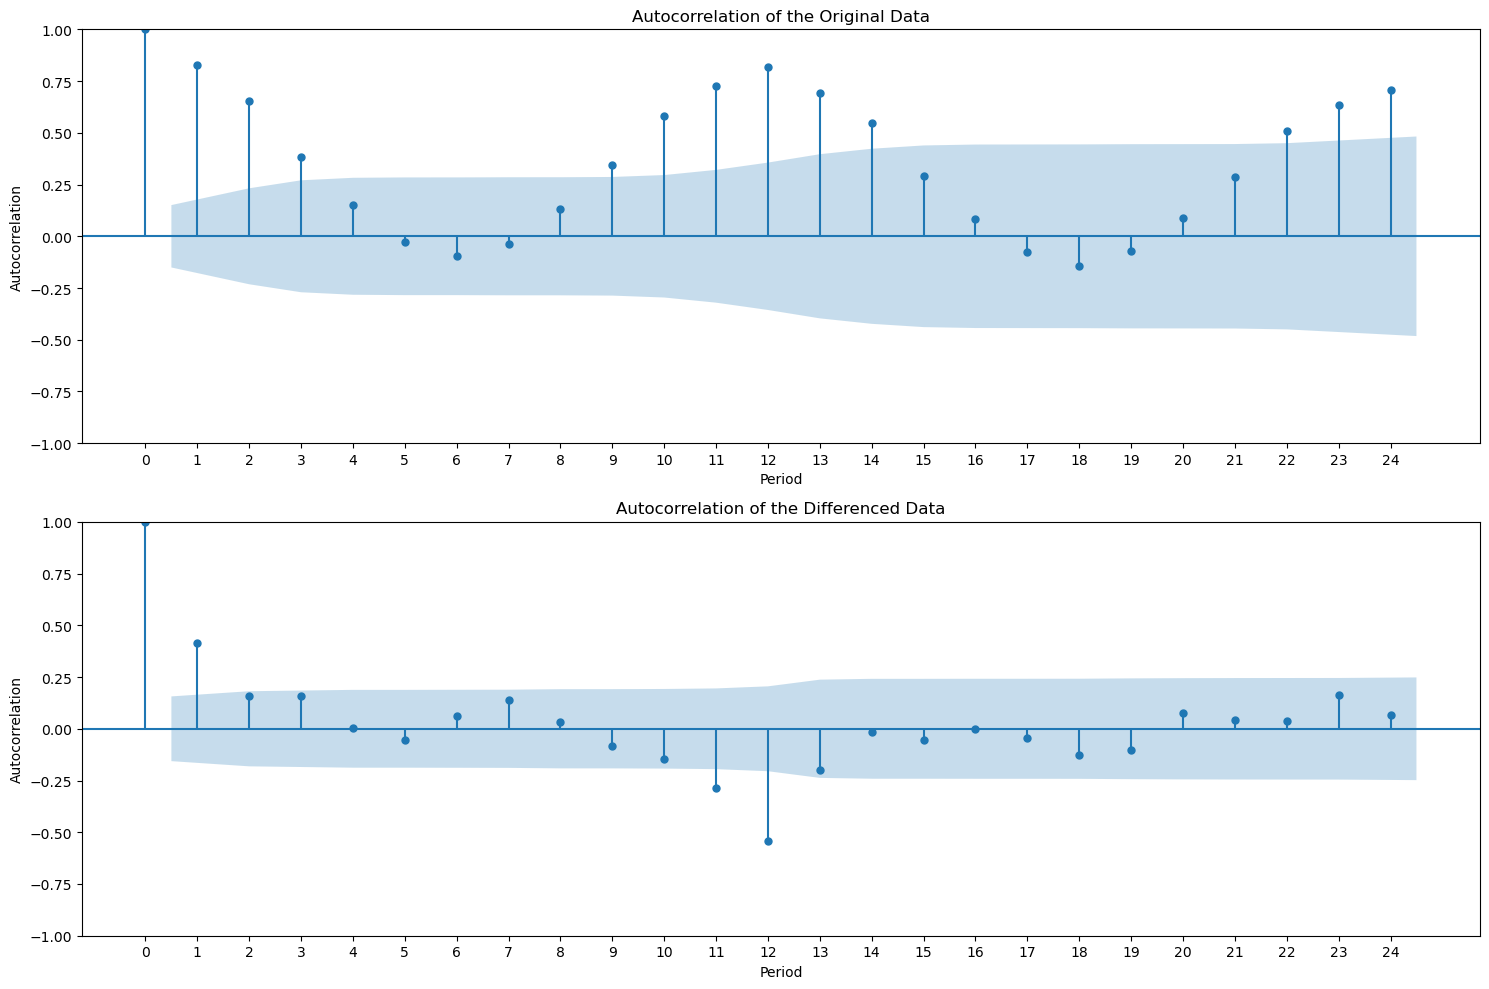

In [465]:
#Plot the ACF plot for both normal and differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plot_acf(df_monthly["nd"], lags=24, ax=ax1)
ax1.set_xlabel('Period')
ax1.set_ylabel('Autocorrelation')
ax1.set_xticks(range(0, 25, 1))
ax1.set_title('Autocorrelation of the Original Data')

plot_acf(df_monthly["diff_1_year"].dropna(), lags=24, ax=ax2)
ax2.set_xlabel('Period')
ax2.set_ylabel('Autocorrelation')
ax2.set_xticks(range(0, 25, 1))
ax2.set_title('Autocorrelation of the Differenced Data')

plt.tight_layout()

plt.show()


The plot of the original data clearly indicates autocorrelation between values that are 11 periods apart. For example, period 6 and period 18 exhibit similar autocorrelation scores. This plot also reveals the seasonal pattern of the series, with a recurring autocorrelation every 12 periods.

The shaded area represents a 95% confidence interval for non-significant correlations. Points outside the shaded area are considered statistically significant autocorrelations.

The step-like pattern observed between similar correlation values is indicative of seasonality. However, it's important to note that the autocorrelation function assumes the series being analyzed is stationary. Therefore, the most informative plot is the second one, which shows the autocorrelation function of the `diff_1_year` column.

Based on the differenced ACF plot, we can tentatively conclude that the q parameter may be 1.

#### **ARIMA Parameters**

The ARIMA model has three parameters,typically denoted as (p, d, q), that can be tunned to get more accurate predictions:

- **p parameter:** The p parameter represents the autoregressive (AR) component, which captures the linear dependence between the current observation and a specific number of lagged observations. It helps the model detect trends and patterns in the data. The value of p corresponds to the number of lagged observations of our dependent variable nd that are considered.

- **d parameter:** The d parameter represents the integrated (I) component, which determines the degree of differencing applied to the time series. Differencing is used to make the time series stationary by subtracting the previous observation from the current observation. It helps remove trends and seasonality from the data. The value of d determines the number of times differencing is applied.

- **q parameter:** The q parameter represents the moving average (MA) component, which captures the dependency between the observed data point and a specific number of lagged forecast errors. It helps model the residual or unexplained variation in the data. The value of q corresponds to the number of lagged forecast errors considered.

The ARIMA model is specified as ARIMA(p, d, q), where these parameters are adjusted to capture the characteristics of the data.

Selecting appropriate values for p, d, and q involves analyzing the autocorrelation and partial autocorrelation functions, considering the stationarity and seasonality of the time series. By adjusting these parameters, the ARIMA model can effectively capture patterns, trends, and dependencies in the data, making it a flexible and powerful tool for time series analysis and forecasting.

In this notebook, we will test the ARIMA model using a simple approach of manually selecting values based on the ACF and PACF plots. Additionally, we will explore a grid-search approach to find the optimal values for p, d, and q.

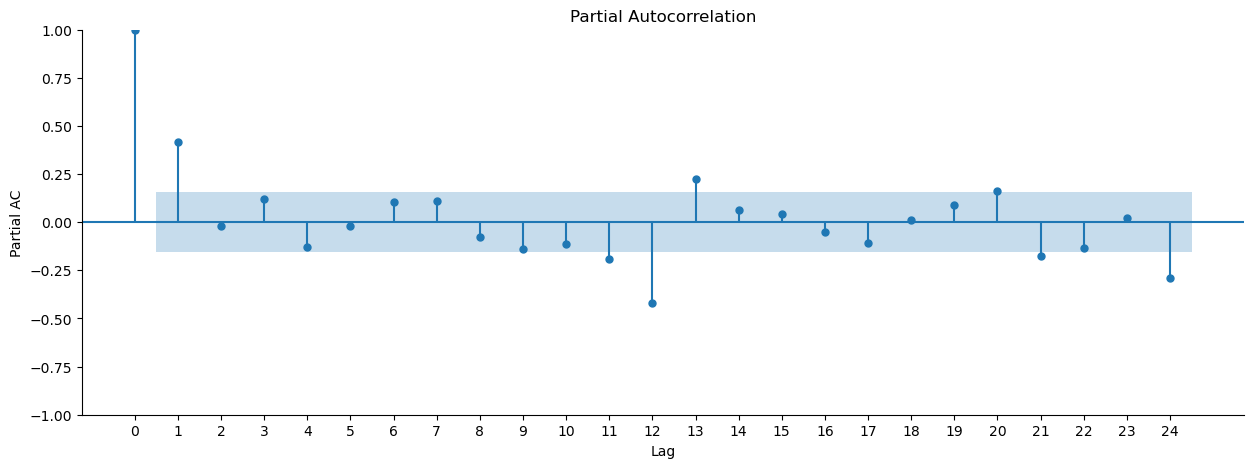

In [466]:
#Plot PACF to determine p parameter
plt.figure(figsize=(15, 5))
plot_pacf(df_monthly["diff_1_year"].dropna(), lags=24, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.xticks(range(0, 25, 1)) 
sns.despine()
plt.show()

From the plot above we could initially set the p parameter to 1 which is the first value before correlation becomes statistically irrelevant. 

In [467]:
#Basic ARIMA model, using the ACF and PACF insights 
#ARIMA
p_param = 1
d_param = 0
q_param = 1

arima = ARIMA(train_diff, order=(p_param, d_param, q_param))
model_fit = arima.fit()

train_arima_predictions = model_fit.predict(start=train_diff.index[0], end=train_diff.index[-1])
test_arima_predictions = model_fit.forecast(test_diff.shape[0])
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            diff_1_year   No. Observations:                  125
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2012.105
Date:                Sun, 25 Jun 2023   AIC                           4032.209
Time:                        13:46:06   BIC                           4043.523
Sample:                    01-01-2010   HQIC                          4036.805
                         - 05-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.066e+06   2.95e+05     -3.618      0.000   -1.64e+06   -4.88e+05
ar.L1         -0.1602      0.193     -0.830      0.407      -0.539       0.218
ma.L1          0.5273      0.156      3.390      0.001       0.222       0.832
sigma2       5.76e+12      0.010   5.91e+14      0.000    5.76e+12    5.76e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.19
Prob(Q):                              0.90   Prob(JB):                         0.20
Heteroskedasticity (H):               0.44   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.55e+31. Standard errors may be unstable.
"""

In [468]:
df_monthly['ARIMA_predict_0'] = (df_monthly['nd'].shift(12) + pd.concat([train_arima_predictions, test_arima_predictions]))

In [469]:
ARIMA_train_mape_0 = mean_absolute_percentage_error(train, df_monthly['ARIMA_predict_0'])
ARIMA_test_mape_0 = mean_absolute_percentage_error(test, df_monthly['ARIMA_predict_0'])
ARIMA_train_mae_0 = mean_absolute_error(train, df_monthly['ARIMA_predict_0'])
ARIMA_test_mae_0 = mean_absolute_error(test, df_monthly['ARIMA_predict_0'])

#Print results
print(f"ARIMA Train MAE: {round(ARIMA_train_mae_0)}")
print(f"ARIMA Test MAE: {round(ARIMA_test_mae_0)}")
print(f"ARIMA Train MAPE: {round(ARIMA_train_mape_0, 2)}%")
print(f"ARIMA Test MAPE: {round(ARIMA_test_mape_0, 2)}%")

ARIMA Train MAE: 1792605
ARIMA Test MAE: 2094835
ARIMA Train MAPE: 3.8%
ARIMA Test MAPE: 5.39%


### **ARIMA Parameter Tunning**

For ARIMA parameter tuning, we will use two functions that iterate over a range of parameters to determine the best combination based on the lowest Mean Absolute Percentage Error (MAPE) evaluation.

In addition to MAPE, we will also consider the Akaike Information Criterion (AIC) to select the optimal parameters. The AIC is a statistical measure used for model selection and comparison, considering both the goodness of fit and the complexity of the model. It operates on the principle of maximum likelihood estimation and penalizes models with more parameters. Our goal is to find the model parameters that minimize the AIC value, striking a balance between goodness of fit and model complexity.

The first function, `arima_evaluation_mape`, calculates the MAPE and AIC for an ARIMA model. It takes the historical data (`history`), which in our case is the `train_diff` values, and the ARIMA parameters (`arima_params`) as inputs. It iterates over the test set, fits an ARIMA model to the `history` data, forecasts the next value, and calculates the MAPE and AIC based on the predictions, it also calculates the number of p-values higher than 0.05 and the overall number of p-values. It returns the MAPE and AIC values.

The second function, `evaluate_model`, runs multiple ARIMA models with different parameter combinations to find the best model. It takes the dataset, p_values (`p`), d_values (`d`), and q_values (`q`) as inputs. It initializes an empty list to store the results and it iterates over all possible combinations of the given parameter, fits an ARIMA model to the dataset using the corresponding parameters, calculates the MAPE and AIC using `arima_evaluation_mape`, and appends the results to the list. It prints the MAPE, AIC, the number of p-values greater than 0.05 and the total count of p-values. Finally, it returns a DataFrame with the results and prints the best model based on the lowest MAPE.

In [470]:
def arima_evaluation_mape(history, arima_params):
    # Make predictions
    history = [x for x in train_diff]
    predictions = []
    for t in range(len(test_diff)):
        model = ARIMA(history, order=arima_params)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test_diff[t])

    # Calculate out-of-sample error, AIC, and p-value count
    error = mean_absolute_percentage_error(test_diff, predictions)
    aic = model_fit.aic
    p_values_count = sum(model_fit.pvalues > 0.05)
    total_p_values = len(model_fit.pvalues)

    return error, aic, p_values_count, total_p_values

In [471]:
def evaluate_model(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    results = []
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mape, aic, p_values_count, total_p_values = arima_evaluation_mape(dataset, order) 
                    result = {
                        'order': order,
                        'mape': mape,
                        'p_values_count': p_values_count,
                        'total_p_values': total_p_values,
                        'aic': aic  
                    }
                    results.append(result)
                    print(f'ARIMA{order} MAPE={mape:.3f}, AIC={aic:.3f}, p-values > 0.05: {p_values_count} out of {total_p_values} p-values')
                    if mape < best_score:
                        best_score, best_cfg = mape, order
                except:
                    continue
    
    result_df = pd.DataFrame(results)
    print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))
    
    return result_df

In [472]:
###############################
###THIS BLOCK HAS A LONG RUN###
###########PICKLED#############
###############################

#ARIMA_evaluation_diff = evaluate_model(train_diff,[0, 1, 2, 3, 4, 6, 8, 10, 12], range(0, 3), range(0, 3))

In [473]:
#joblib.dump(ARIMA_evaluation_diff, '../model/ARIMA_evaluation_diff.pkl')

In [474]:
ARIMA_evaluation_diff = joblib.load('../model/ARIMA_evaluation_diff.pkl')

In [475]:
ARIMA_evaluation_diff.sort_values('mape', ascending=True).head()

,order,mape,p_values_count,total_p_values,aic
41,"(4, 1, 2)",99.438710,3,7,4998.156839
32,"(3, 1, 2)",100.886533,2,6,4997.146559
20,"(2, 0, 2)",101.194626,2,6,5024.365946
19,"(2, 0, 1)",104.175840,0,5,5022.999047
23,"(2, 1, 2)",104.401794,1,5,4996.207439


From the `ARIMA_evaluation` df we can see that the top 3 parameter orders in terms of low MAPE have multiple p-values higher than 0.05, meaning that the parameters are not statistically significant and therefore are not good indicators for a forecast. 

Having that said, we will go with the (4, 0, 2) order wich has only one p-value above the threshold. 

#### **ARIMA fitting and results**

Since the ARIMA model assumes the series is stationary, we tunned the parameters using the differenced data column `diff_1_year`. 

In [476]:
#ARIMA
p_param = 4
d_param = 0
q_param = 2

arima = ARIMA(train_diff, order=(p_param, d_param, q_param))
arima_model_fit = arima.fit()

#Save model
#Save the model
joblib.dump(arima_model_fit, '../model/monthly_arima.pkl')

#Make predictions
train_arima_predictions = arima_model_fit.predict(start=train_diff.index[0], end=train_diff.index[-1])
test_arima_predictions = arima_model_fit.forecast(test_diff.shape[0])

arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            diff_1_year   No. Observations:                  125
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -2006.443
Date:                Sun, 25 Jun 2023   AIC                           4028.886
Time:                        13:46:06   BIC                           4051.513
Sample:                    01-01-2010   HQIC                          4038.078
                         - 05-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.066e+06   1.58e-08  -6.73e+13      0.000   -1.07e+06   -1.07e+06
ar.L1         -0.0217      0.095     -0.229      0.819      -0.207       0.164
ar.L2         -0.8363      0.089     -9.354      0.000      -1.011      -0.661
ar.L3          0.4068      0.073      5.573      0.000       0.264       0.550
ar.L4         -0.0831      0.091     -0.913      0.361      -0.262       0.095
ma.L1          0.3977      0.052      7.660      0.000       0.296       0.499
ma.L2          0.9850      0.106      9.277      0.000       0.777       1.193
sigma2      5.137e+12   8.48e-15   6.06e+26      0.000    5.14e+12    5.14e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.91   Prob(JB):                         0.73
Heteroskedasticity (H):               0.49   Skew:                             0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.28e+41. Standard errors may be unstable.
"""

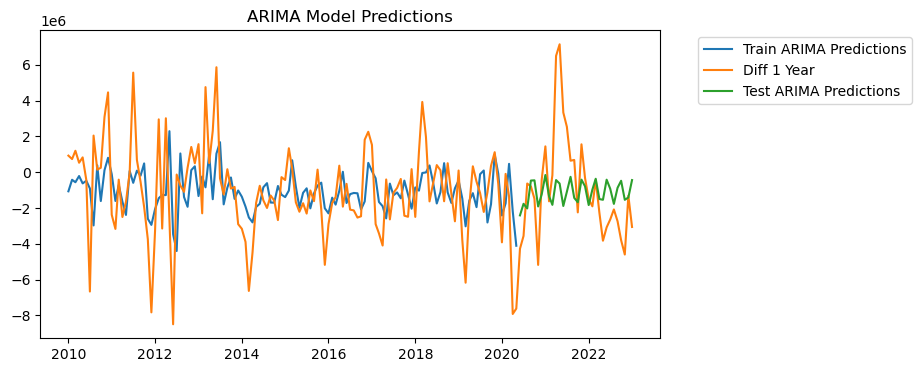

In [477]:
#Plot predictions against differenced data
plt.figure(figsize=(8, 4))
plt.plot(train_arima_predictions, label='Train ARIMA Predictions')
plt.plot(df_monthly['diff_1_year'], label='Diff 1 Year')
plt.plot(test_arima_predictions, label='Test ARIMA Predictions')

plt.title('ARIMA Model Predictions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

From the plot above, we can observe that our model in the train set somewhat captures the pattern of the differenced data. However, it fails to detect the high and low peaks of variation accurately. The test predictions appear to be cyclic and do not demonstrate strong predictive ability.

#### **Reconstruct forecast**

Since the predictions were made in the differenced data we need to reconstruct the predictions to be able to visualize it with the original data train and test set. This proccess implies adding the differenced predictions with the original data of the previous year using the `.shift` pandas method.

In [478]:
#Concatenate predictions and store them in the df
df_monthly['ARIMA_predict'] = (df_monthly['nd'].shift(12) + pd.concat([train_arima_predictions, test_arima_predictions]))

In [479]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, name="Test"))
fig.add_trace(go.Scatter(x=test.index, y=df_monthly.loc[test.index, 'ARIMA_predict'], name="ARIMA prediction"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title={
        'text': "<b>ND ARIMA prediction<b>",
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',},
    yaxis_title="MW"
)

fig.show()

In [480]:
df_monthly['ARIMA_predict'].fillna(0, inplace=True)
df_monthly['ARIMA_predict'].interpolate(method='linear', inplace=True)

In [481]:
ARIMA_train_mape = mean_absolute_percentage_error(train, df_monthly.loc[train.index, 'ARIMA_predict'])
ARIMA_test_mape = mean_absolute_percentage_error(test, df_monthly.loc[test.index, 'ARIMA_predict'])
ARIMA_train_mae = mean_absolute_error(train, df_monthly.loc[train.index, 'ARIMA_predict'])
ARIMA_test_mae = mean_absolute_error(test, df_monthly.loc[test.index, 'ARIMA_predict'])

#Print results
print(f"ARIMA baseline Train MAE: {round(ARIMA_train_mae)}")
print(f"ARIMA baseline Test MAE: {round(ARIMA_test_mae)}")
print(f"ARIMA baseline Train MAPE: {round(ARIMA_train_mape, 2)}%")
print(f"ARIMA baseline Test MAPE: {round(ARIMA_test_mape, 2)}%")

ARIMA baseline Train MAE: 6198869
ARIMA baseline Test MAE: 1990700
ARIMA baseline Train MAPE: 12.24%
ARIMA baseline Test MAPE: 5.15%


In [482]:
results.loc[results['model'] == 'ARIMA', 'Train_MAE'] = ARIMA_train_mae
results.loc[results['model'] == 'ARIMA', 'Test_MAE'] = ARIMA_test_mae
results.loc[results['model'] == 'ARIMA', 'Train_MAPE'] = ARIMA_train_mape
results.loc[results['model'] == 'ARIMA', 'Test_MAPE'] = ARIMA_test_mape
results['model'].replace({'ARIMA': 'ARIMA(4,0,2)'}, inplace=True)

results

,model,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE
0,Simple_Mean,3.957661,5.488195,1.867551e+06,2.126467e+06
1,Rolling_AVG,5.310872,5.135859,2.520438e+06,2.122838e+06
2,"ARIMA(4,0,2)",12.243213,5.152527,6.198869e+06,1.990700e+06
3,"SARIMA(3,1,2)x(0,1,3,12)",4.567475,7.047027,2.184182e+06,2.740520e+06
4,"SARIMAX(3,1,2)x(0,1,3,12)",3.431899,3.730760,1.608049e+06,1.417350e+06


The ARIMA model performed poorly in the train set but it improved in the test set. 

### **3. SARIMA**

The SARIMA (Seasonal ARIMA) model incorporates seasonal components into the ARIMA framework, which is particularly relevant in the case of energy consumption, as it often exhibits seasonal patterns and fluctuations. We anticipate that the SARIMA model will outperform the ARIMA model as it considers both the seasonal and non-seasonal components.

The SARIMA model expects four additional parameters P, D, Q and s: 
- P: is the order of the seasonal autoregressive component (p), which captures how seasons affect the targer variable. <br>
- D: is the degree of seasonal differencing, similar to d but applied to the seasonal component (were arw going to set d and D to the same fixed value).<br>
- Q: is the order of the seasonal moving average component (q).<br>
- s: the length of the seasonal cycle or period, which in our case is 12 for the 12 months of the year. 

For the SARIMA model we are going to use a grid search that will give us the optimal paramater tunning. 

In [483]:
#Select parameters limits for iteration
ps = range(0, 4)
d = 1
qs = range(0, 4)
Ps = range(0, 4)
D = 1
Qs = range(0, 4)
s = 12

In [484]:
#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
f"Number of parameters to test {len(parameters_list)}"

'Number of parameters to test 256'

#### **SARIMA Parameter Optimization**

The following function performs the optimization for a SARIMA model by iterating over a list of parameter combinations and selecting the model with the lowest AIC (Akaike Information Criterion).

This is a step-by-step explanation of what the function performs:

1. It initializes an empty list `results` to store the results of each model and sets the initial value of best_aic to infinity.
2. It iterates over the `parameters_list`, which contains different combinations of SARIMA parameters.
3. Inside the loop, it tries to fit a SARIMAX model with the current parameter combination to the train data. If the fitting fails, it continues to the next iteration.
4. It calculates the AIC value of the fitted model, the count of p-values greater than 0.05, and the total number of p-values.
5. It compares the current AIC value with the current `best_aic` value. If the new AIC value is lower, it updates `best_model`, `best_aic`, and `best_param` with the current model, AIC value, and parameter combination, respectively.
6. It appends the parameter combination, AIC value, p-values count, and total p-values to the `results` list.
7. After iterating over all parameter combinations, it creates a dataframe `result_table` using the collected results and renames the columns of result_table and sorts it based on the AIC values in ascending order.
8. Finally, it returns the result_table as the output of the function.

The resulting `result_table` provides a summary of the optimization process, showing the AIC values, p-values count, and total p-values for each parameter combination. The table is sorted in ascending order of AIC, allowing the selection of the model with the lowest AIC as the optimal SARIMA model.

In [485]:
# Iterate on multiple SARIMA models to tune the hyperparameters
def optimize_SARIMA(parameters_list, d, D, s):  
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(train, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        p_values_count = sum(model.pvalues > 0.05)
        total_p_values = len(model.pvalues)
        
        # Save best model, AIC, parameters, and p-values information
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, aic, p_values_count, total_p_values])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'AIC', 'p_values_count', 'total_p_values']
    result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_table


In [486]:
#################################
##THIS BLOCK HAS A LONG RUNTIME##
##############PICKLED############
#################################

#SARIMA_result_table = optimize_SARIMA(parameters_list, d, D, s)

In [487]:
#joblib.dump(SARIMA_result_table, '../model/SARIMA_result_table.pkl')

In [488]:
SARIMA_result_table = joblib.load('../model/SARIMA_result_table.pkl')
SARIMA_result_table

,parameters,AIC,p_values_count,total_p_values
0,"(3, 2, 0, 3)",4008.114472,1,9
1,"(3, 2, 2, 1)",4009.213508,1,9
2,"(2, 2, 1, 2)",4011.311806,0,8
3,"(2, 2, 1, 3)",4011.661121,4,9
4,"(3, 2, 3, 2)",4012.359115,2,11
...,...,...,...,...
251,"(0, 0, 2, 2)",4095.667052,1,5
252,"(0, 0, 2, 3)",4098.685394,1,6
253,"(0, 0, 3, 0)",4106.912903,0,4
254,"(0, 0, 3, 3)",4118.071365,3,7


#### **SARIMA Fitting**

In [489]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = SARIMA_result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

# Predict using the fitted model
train_sarima_predictions = best_model.predict(start=train.index[0], end=train.index.max())
test_sarima_predictions = best_model.forecast(test.shape[0])

print(best_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                         nd   No. Observations:                  137
Model:             SARIMAX(3, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1995.057
Date:                                    Sun, 25 Jun 2023   AIC                           4008.114
Time:                                            13:46:10   BIC                           4033.497
Sample:                                        01-01-2009   HQIC                          4018.425
                                             - 05-01-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5260      0.046    -32.824      0

The AIC (Akaike Information Criterion) is employed as the metric to select the optimal parameters. This criterion captures the balance between model complexity and goodness of fit. The goal is to choose the model that explains the highest amount of variation with the fewest independent variables possible.

In [490]:
#Store predictions in the df
df_monthly['SARIMA_predict'] = pd.concat([train_sarima_predictions, test_sarima_predictions])

df_monthly['SARIMA_predict']

settlement_date
2009-01-01    0.000000e+00
2009-02-01    6.135753e+07
2009-03-01    5.454405e+07
2009-04-01    5.830782e+07
2009-05-01    4.861837e+07
                  ...     
2022-09-01    2.194702e+07
2022-10-01    2.695052e+07
2022-11-01    3.073233e+07
2022-12-01    3.225667e+07
2023-01-01    3.477934e+07
Name: SARIMA_predict, Length: 169, dtype: float64

In [491]:
#Reconstruct first value
df_monthly.SARIMA_predict.iloc[0]=df_monthly.SARIMA_predict.iloc[1]

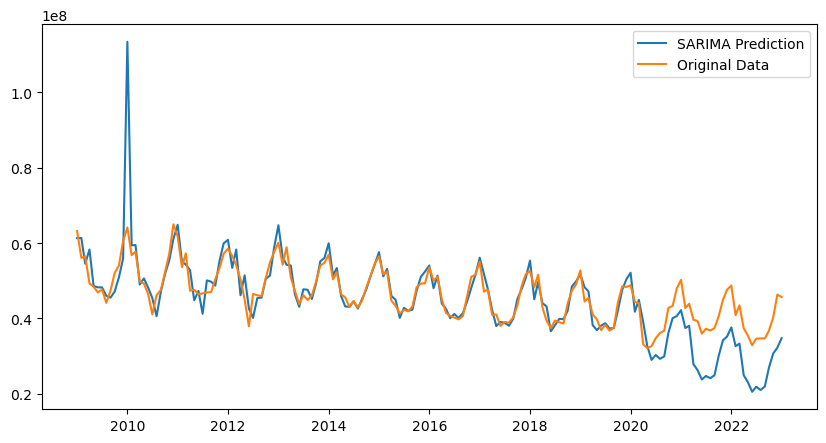

In [492]:
plt.plot(df_monthly['SARIMA_predict'], label='SARIMA Prediction')
plt.plot(df_monthly['nd'], label='Original Data')
plt.legend()
plt.show()

The forecast seems to have a weird outlier in the first 12 month cycle, we will impute this value using the `.interpolate` method. 

In [493]:
#locate outlier value and replace with null
df_monthly.SARIMA_predict.iloc[12] = np.NaN
df_monthly['SARIMA_predict'].interpolate(method='linear', limit=1, inplace=True, limit_direction='both', limit_area='inside')

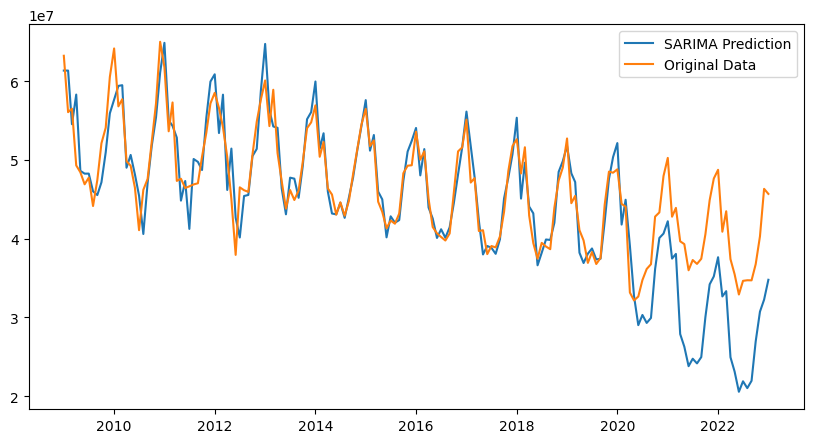

In [494]:
plt.plot(df_monthly['SARIMA_predict'], label='SARIMA Prediction')
plt.plot(df_monthly['nd'], label='Original Data')
plt.legend()
plt.show()

In [495]:
SARIMA_train_mape = mean_absolute_percentage_error(train, df_monthly.loc[train.index, 'SARIMA_predict'])
SARIMA_test_mape = mean_absolute_percentage_error(test, df_monthly.loc[test.index, 'SARIMA_predict'])
SARIMA_train_mae = mean_absolute_error(train, df_monthly.loc[train.index, 'SARIMA_predict'])
SARIMA_test_mae = mean_absolute_error(test, df_monthly.loc[test.index, 'SARIMA_predict'])

#Print results
print(f"SARIMA baseline Train MAE: {round(SARIMA_train_mae)}")
print(f"SARIMA baseline Test MAE: {round(SARIMA_test_mae)}")
print(f"SARIMA baseline Train MAPE: {round(SARIMA_train_mape, 2)}%")
print(f"SARIMA baseline Test MAPE: {round(SARIMA_test_mape, 2)}%")

SARIMA baseline Train MAE: 1964548
SARIMA baseline Test MAE: 9899163
SARIMA baseline Train MAPE: 4.07%
SARIMA baseline Test MAPE: 25.16%


The results of the SARIMA model are not satisfactory, considering that it was expected to outperform the ARIMA model by incorporating both seasonal and non-seasonal components. One possible reason for this underperformance could be the inability of the model to capture the underlying trend or patterns in the data. To improve the results, we will experiment with modifications to the train and test sets to observe the impact on the predictive performance.

In [496]:
#Create new trainset
train_2 = df_monthly.loc[df_monthly.index <= "2020-02-28", 'nd']
test_2 = df_monthly.loc[df_monthly.index > "2020-02-28", 'nd']

In [497]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = SARIMA_result_table.parameters[0]

sarima_model_fit = sm.tsa.statespace.SARIMAX(train_2, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

#Save the model
joblib.dump(sarima_model_fit, '../model/monthly_sarima.pkl')

# Predict using the fitted model
train2_sarima_predictions = sarima_model_fit.predict(start=train_2.index[0], end=train_2.index[-1])
test2_sarima_predictions = sarima_model_fit.forecast(test_2.shape[0])

print(best_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                         nd   No. Observations:                  137
Model:             SARIMAX(3, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1995.057
Date:                                    Sun, 25 Jun 2023   AIC                           4008.114
Time:                                            13:46:12   BIC                           4033.497
Sample:                                        01-01-2009   HQIC                          4018.425
                                             - 05-01-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5260      0.046    -32.824      0

In [498]:
#Store predictions in the df
df_monthly['SARIMA_predict2'] = pd.concat([train2_sarima_predictions, test2_sarima_predictions])

df_monthly['SARIMA_predict2']

settlement_date
2009-01-01    0.000000e+00
2009-02-01    6.060918e+07
2009-03-01    5.220367e+07
2009-04-01    5.870010e+07
2009-05-01    4.902310e+07
                  ...     
2022-09-01    3.908605e+07
2022-10-01    4.364589e+07
2022-11-01    4.744786e+07
2022-12-01    4.921472e+07
2023-01-01    5.269938e+07
Name: SARIMA_predict2, Length: 169, dtype: float64

In [499]:
#locate outlier value and replace with null and interpolate 
df_monthly.SARIMA_predict2.iloc[0]=df_monthly.SARIMA_predict2.iloc[1]
df_monthly.SARIMA_predict2.iloc[12] = np.NaN
df_monthly['SARIMA_predict2'].interpolate(method='linear', limit=1, inplace=True, limit_direction='both', limit_area='inside')

In [500]:
#Plot predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_2.index, y=train_2, name="Train"))
fig.add_trace(go.Scatter(x=test_2.index, y=test_2, name="Test"))
fig.add_trace(go.Scatter(x=test_2.index, y=df_monthly.loc[test_2.index, 'SARIMA_predict2'], name="SARIMA 2nd prediction"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title={
        'text': "<b>ND SARIMA prediction<b>",
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',},
    yaxis_title="MW"
)

fig.show()

In [501]:
SARIMA_train_mape = mean_absolute_percentage_error(train, df_monthly.loc[train.index, 'SARIMA_predict2'])
SARIMA_test_mape = mean_absolute_percentage_error(test, df_monthly.loc[test.index, 'SARIMA_predict2'])
SARIMA_train_mae = mean_absolute_error(train, df_monthly.loc[train.index, 'SARIMA_predict2'])
SARIMA_test_mae = mean_absolute_error(test, df_monthly.loc[test.index, 'SARIMA_predict2'])

#Print results
print(f"SARIMA baseline Train MAE: {round(SARIMA_train_mae)}")
print(f"SARIMA baseline Test MAE: {round(SARIMA_test_mae)}")
print(f"SARIMA baseline Train MAPE: {round(SARIMA_train_mape, 2)}%")
print(f"SARIMA baseline Test MAPE: {round(SARIMA_test_mape, 2)}%")

SARIMA baseline Train MAE: 2184182
SARIMA baseline Test MAE: 2740520
SARIMA baseline Train MAPE: 4.57%
SARIMA baseline Test MAPE: 7.05%


In [502]:
results.loc[results['model'] == 'SARIMA', 'Train_MAE'] = SARIMA_train_mae
results.loc[results['model'] == 'SARIMA', 'Test_MAE'] = SARIMA_test_mae
results.loc[results['model'] == 'SARIMA', 'Train_MAPE'] = SARIMA_train_mape
results.loc[results['model'] == 'SARIMA', 'Test_MAPE'] = SARIMA_test_mape
results['model'].replace({'SARIMA': 'SARIMA(3,1,2)x(0,1,3,12)'}, inplace=True)

results

,model,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE
0,Simple_Mean,3.957661,5.488195,1.867551e+06,2.126467e+06
1,Rolling_AVG,5.310872,5.135859,2.520438e+06,2.122838e+06
2,"ARIMA(4,0,2)",12.243213,5.152527,6.198869e+06,1.990700e+06
3,"SARIMA(3,1,2)x(0,1,3,12)",4.567475,7.047027,2.184182e+06,2.740520e+06
4,"SARIMAX(3,1,2)x(0,1,3,12)",3.431899,3.730760,1.608049e+06,1.417350e+06


### **4. SARIMAX**

The SARIMAX model extends the SARIMA model by incorporating exogenous variables in addition to the seasonal and non-seasonal components. In our case, we will include temperature as an exogenous variable to assess its impact on the model. By incorporating exogenous variables, such as weather data, economic indicators, or other relevant factors, into the SARIMAX model, we can leverage additional information to enhance the accuracy of the forecasts. This expanded modeling approach allows us to capture the influence of these external factors on energy consumption and improve the predictive capabilities of the model.

#### **Load and set Exogenous Temperature Variable**

To better inform our SARIMAX model we are going to test variables from the original dataset and use UK average temperature in Celsius degrees to check if they better inform our predictions. 

In [503]:
temp = pd.read_csv('../data/temperature_data.csv', index_col=0)
temp

,temperature
date,
2009-01-01,5.7
2009-02-01,6.4
2009-03-01,9.9
2009-04-01,13.3
2009-05-01,15.3
...,...
2023-01-01,7.3
2023-02-01,9.0
2023-03-01,8.9


In [504]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 2009-01-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  173 non-null    float64
dtypes: float64(1)
memory usage: 2.7+ KB


In [505]:
#Set index to datetime
temp = temp.set_index(pd.to_datetime(temp.index))

#Include in the df
df_monthly['temp'] = temp

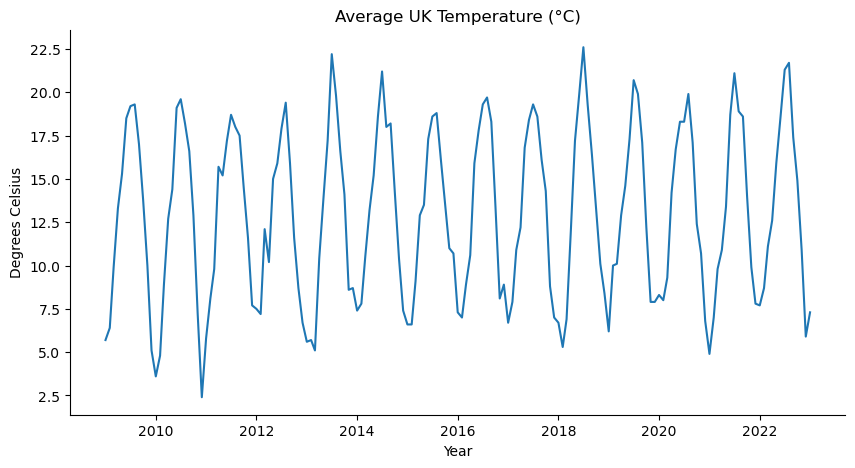

In [506]:
#Plot temperature
plt.plot(df_monthly['temp'])
plt.xlabel('Year')
plt.ylabel('Degrees Celsius')
plt.title('Average UK Temperature (°C)')
sns.despine()
plt.show()

We are going to drop `tsd` and `england_wales_demand` because they inform our target variable `nd`.

#### Check for multicolinearity between variables

In [507]:
#Create a copy of the DF to compare selected variables
df_sarimax = df_monthly.copy()

In [508]:
#Drop unnecesary variables. 
df_sarimax.drop(columns=['tsd','england_wales_demand', 'is_holiday', 'trend_nd', 'seasonal_nd', 'residual_nd',
       'diff_1_year','mean_predict', 'rolling_avg', 'SARIMA_predict', 'SARIMA_predict2', 'ARIMA_predict_0',
       'ARIMA_predict'], inplace=True)


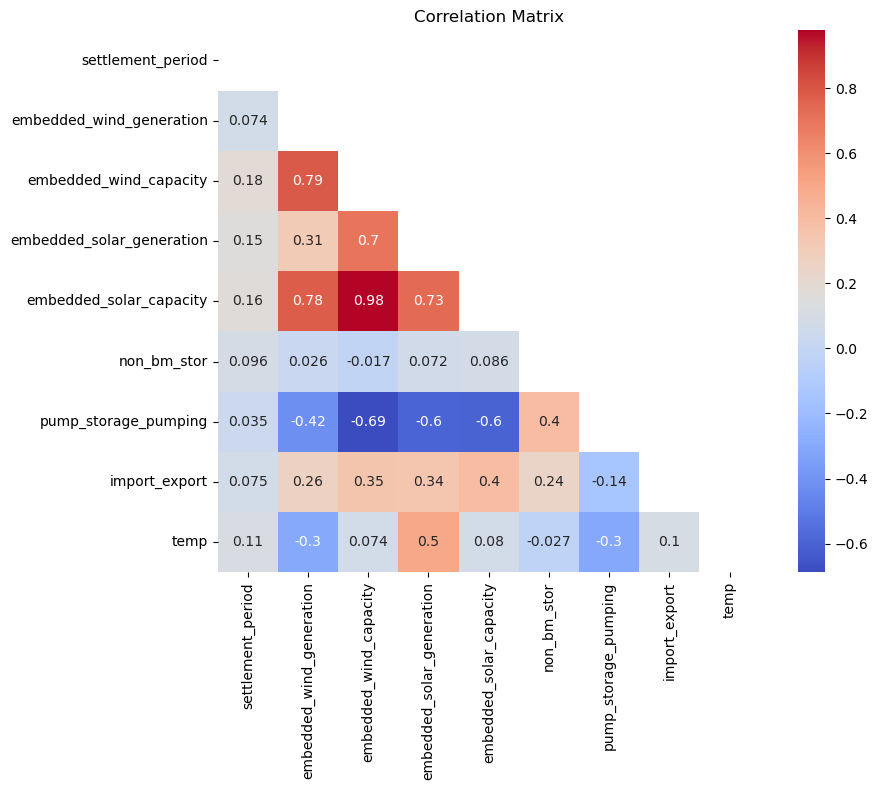

In [509]:
correlation_matrix = df_sarimax.drop('nd', axis=1).corr()

# Create a mask to hide the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, mask=mask)

# Customize the plot
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

From the correlation matrix we can see that `embedded_solar_capacity` is highly correlated with `embedded_wind_capacity`, therefore we are going to drop all the solar related columns. 

In [510]:
df_sarimax.drop(columns=['embedded_solar_capacity', 'embedded_solar_generation'], inplace=True)

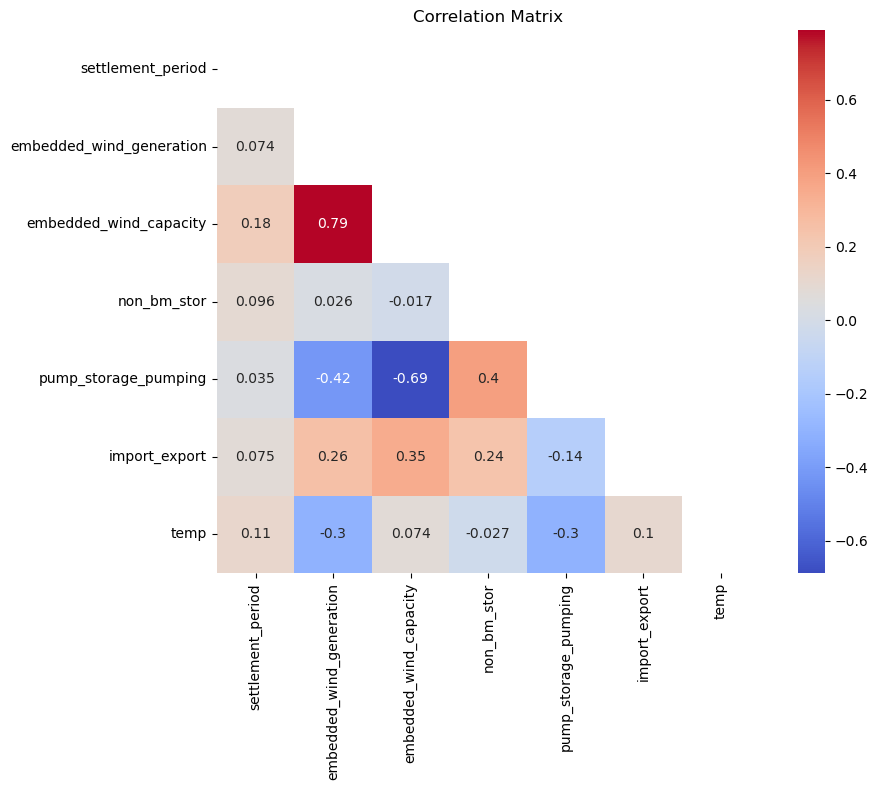

In [511]:
correlation_matrix = df_sarimax.drop('nd', axis=1).corr()

# Create a mask to hide the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, mask=mask)

# Customize the plot
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

The plot above provides us with a clearer understanding of the variables that will be useful for our SARIMAX model. In our modeling approach, we will exclude the `pump_storage_energy` variable since it is likely influenced by our target variable, national demand. As for wind, we will focus specifically on the generation aspect of the variable. By selecting these relevant variables, we can ensure that our SARIMAX model captures the necessary information without introducing any potential issues of multicollinearity or endogeneity.

### **SARIMAX parameters**

We will proceed with running the SARIMAX model, using the same variables as in the SARIMA model. Initially, we will include all the selected exogenous variables. Subsequently, we will iterate over different combinations of variables to optimize for both the AIC and the statistical significance of the variables (p-values). This iterative process will help us identify the most effective combination of exogenous variables to enhance the accuracy and interpretability of our SARIMAX model. 

In [512]:
# SARIMAX Parameters SARIMA(3, 1, 2)x(0, 1, 3, 12)
p = 3
d = 1
q = 2
P = 0
D = 1
Q = 3
s = 12

In [513]:
# Define the exogenous variables
exog_variables = df_monthly.loc[train.index, ['import_export', 'embedded_solar_generation', 'temp']] 

order = (p, d, q)
seasonal_order = (P, D, Q, s) 

model = SARIMAX(endog=train, exog=exog_variables, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Make predictions
train_sarimax_predictions = model_fit.predict(start=train.index[0], end=train.index.max(),
                                              exog=exog_variables)
test_sarimax_predictions = model_fit.predict(start=test.index[0], end=test.index.max(),
                                              exog=df_monthly.loc[test.index, ['temp', 'embedded_solar_generation', 'import_export']])

print(model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                         nd   No. Observations:                  137
Model:             SARIMAX(3, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1980.656
Date:                                    Sun, 25 Jun 2023   AIC                           3985.312
Time:                                            13:46:17   BIC                           4019.155
Sample:                                        01-01-2009   HQIC                          3999.060
                                             - 05-01-2020                                         
Covariance Type:                                      opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
import_export       

Our first attemp shows that some `temp` and `import_export` columns have a good statistical relationship with the target variable. `embedded_solar_generation` p-value exceeds 0.05 which means that the coefficient for ehis variable is not statistically significant and will not inform our model properly.

In [514]:
#Store predictions in the DF
df_monthly['SARIMAX_predict'] = pd.concat([train_sarimax_predictions, test_sarimax_predictions])
df_monthly['SARIMAX_predict']

settlement_date
2009-01-01   -4.126502e+06
2009-02-01    5.836066e+07
2009-03-01    4.897023e+07
2009-04-01    5.625481e+07
2009-05-01    4.746870e+07
                  ...     
2022-09-01    1.588456e+12
2022-10-01    1.455725e+12
2022-11-01    1.416382e+12
2022-12-01   -1.195041e+12
2023-01-01   -1.575306e+12
Name: SARIMAX_predict, Length: 169, dtype: float64

In [515]:
#Locate outlier value and replace with null and interpolate
df_monthly.SARIMAX_predict.iloc[0]=df_monthly.SARIMAX_predict.iloc[1]
df_monthly.SARIMAX_predict.iloc[12] = np.NaN
df_monthly['SARIMAX_predict'].interpolate(method='linear', limit=1, inplace=True, limit_direction='both', limit_area='inside')

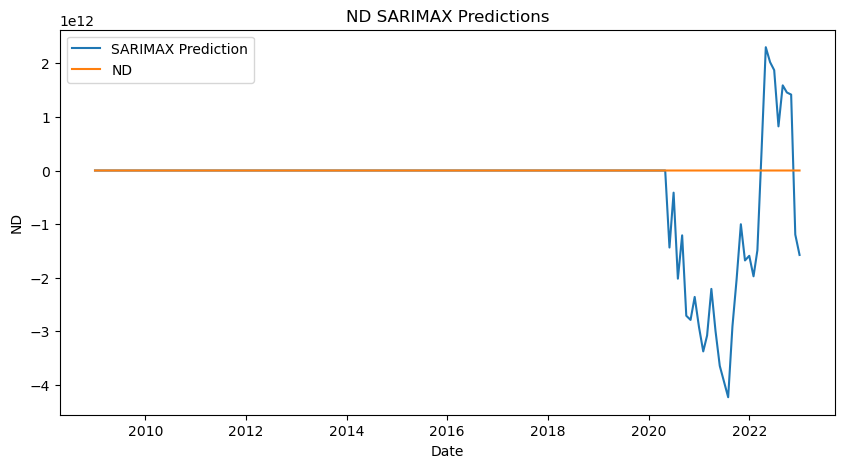

In [516]:
#Plot predictions against original results 
plt.plot(df_monthly['SARIMAX_predict'], label='SARIMAX Prediction')
plt.plot(df_monthly['nd'], label='ND')

plt.title('ND SARIMAX Predictions')
plt.xlabel('Date')
plt.ylabel('ND')
plt.legend() 
plt.show()

The plot above shows that the model has several distotions in the high peaks of years 2011, 2014, 2015, 2018 and 2022. We are going to check the error metrics and iterate on the exogenous variables. The model also has problems in the early years to follow the seasonality of the data as it has more fluctuations that the original data. 

In [517]:
SARIMAX_train_mape = mean_absolute_percentage_error(train, df_monthly.loc[train.index, 'SARIMAX_predict'])
SARIMAX_test_mape = mean_absolute_percentage_error(test, df_monthly.loc[test.index, 'SARIMAX_predict'])
SARIMAX_train_mae = mean_absolute_error(train, df_monthly.loc[train.index, 'SARIMAX_predict'])
SARIMAX_test_mae = mean_absolute_error(test, df_monthly.loc[test.index, 'SARIMAX_predict'])

#Print results
print(f"SARIMAX Train MAE: {round(SARIMAX_train_mae)}")
print(f"SARIMAX Test MAE: {round(SARIMAX_test_mae)}")
print(f"SARIMAX Train MAPE: {round(SARIMAX_train_mape, 2)}%")
print(f"SARIMAX Test MAPE: {round(SARIMAX_test_mape, 2)}%")

SARIMAX Train MAE: 1605313
SARIMAX Test MAE: 2082750497883
SARIMAX Train MAPE: 3.4%
SARIMAX Test MAPE: 5244421.41%


The results above are not positive, to check our intuition that solar generation does not provide useful information to the model ew are going to iterate on the three exogenous variables. 

### **Exogenous Variables Iteration**
The following codeblock performs model selection for a SARIMAX model by iterating over different combinations of exogenous variables and evaluating the models based on their AIC (Akaike Information Criterion) values.

This the step by step of the function:

1. It sets the parameters (p, q, P, Q) for the SARIMAX model based on the combination with the lowest AIC from the ``result_table` stored in the ARIMA iteration.
2. It defines the `exog_variables` dataframe, which contains the set exogenous variables for the model. In order to prevent data leakeage, this dataframe is sliced from `df_monthly` using the train index.
3. It initializes empty lists `exog_combinations`, `aic_values`, `p_values_greater_than_05`, and `total_p_values` to store the results of different model combinations.
4. It iterates over different combinations of exogenous variables using the combinations function from the itertools module.
5. For each combination, it fits a SARIMAX model (`best_model`) with the current exogenous variables and the previously set SARIMA parameters.
6. It appends the combination of exogenous variables, AIC value, number of p-values greater than 0.05, and total number of p-values to the respective lists.
7. After iterating over all combinations, it creates a dataframe (`result_df`) using the collected results.
8. Finally, the `result_df` is sorted based on the AIC values in ascending order.

The resulting dataframe provides a summary of the model selection process, showing the AIC values for each combination of exogenous variables and the number of p-values greater than 0.05. This information will be used to choose the best model based on the AIC criterion and the significance of the variables.

In [518]:
# Set parameters that give the lowest AIC
p, q, P, Q = SARIMA_result_table.parameters[0]
exog_variables = df_monthly.loc[train.index, ['import_export', 'embedded_solar_generation', 'temp']]
exog_combinations = []
aic_values = []
p_values_greater_than_05 = []
total_p_values = []

# Iterate over different combinations of exogenous variables
for r in range(1, len(exog_variables.columns) + 1):
    combinations = itertools.combinations(exog_variables.columns, r)
    
    for combination in combinations:
        current_exog = exog_variables[list(combination)]
        
        best_model = sm.tsa.statespace.SARIMAX(train, exog=current_exog, order=(p, d, q),
                                               seasonal_order=(P, D, Q, s)).fit(disp=-1)
        
        exog_combinations.append(combination)
        aic_values.append(best_model.aic)
        p_values = best_model.pvalues
        p_values_greater_than_05.append(sum(p_values > 0.05))
        total_p_values.append(len(p_values))
        
# Create a dataframe with the results
result_df = pd.DataFrame({
    'Exog_Variables': exog_combinations,
    'AIC': aic_values,
    'P_Values_Greater_Than_05': p_values_greater_than_05,
    'Total_P_Values': total_p_values
})

result_df.sort_values('AIC', ascending=True)

,Exog_Variables,AIC,P_Values_Greater_Than_05,Total_P_Values
4,"(import_export, temp)",3967.212929,1,11
5,"(embedded_solar_generation, temp)",3973.363480,1,11
6,"(import_export, embedded_solar_generation, temp)",3985.311879,2,12
2,"(temp,)",3986.139153,5,10
0,"(import_export,)",4006.103612,2,10
3,"(import_export, embedded_solar_generation)",4010.251926,2,11
1,"(embedded_solar_generation,)",4015.123946,1,10


From the grid serach above we can conclude that the most statistically relevant exogenous variables to use in the SARIMAX model are `import_export`and `temp`.

In [519]:
p, q, P, Q = SARIMA_result_table.parameters[0]

#Select best performing exogenous variables
exog_variables = df_monthly.loc[train_2.index, ['temp', 'import_export',]]

sarimax_model = sm.tsa.statespace.SARIMAX(train_2, exog=exog_variables, order=(p, d, q),
                                          seasonal_order=(P, D, Q, s))
sarimax_model_fit = sarimax_model.fit(disp=-1)

# Make predictions
train_sarimax_predictions = sarimax_model_fit.predict(start=train_2.index[0], end=train_2.index.max(),
                                                      exog=exog_variables)
test_sarimax_predictions = sarimax_model_fit.forecast(steps=len(test_2),
                                                      exog=df_monthly.loc[test_2.index, [ 'temp','import_export']])

print(sarimax_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                         nd   No. Observations:                  134
Model:             SARIMAX(3, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1923.246
Date:                                    Sun, 25 Jun 2023   AIC                           3868.492
Time:                                            13:46:41   BIC                           3899.246
Sample:                                        01-01-2009   HQIC                          3880.983
                                             - 02-01-2020                                         
Covariance Type:                                      opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temp          -7.227e+05    4.5e-08  -1.61e+

In [520]:
# Save the model
joblib.dump(sarimax_model_fit, '../model/monthly_sarimax.pkl')

['../model/monthly_sarimax.pkl']

In [521]:
sarimax_model_fit.pvalues

temp              0.000000e+00
import_export     1.211397e-01
ar.L1             0.000000e+00
ar.L2            2.959173e-155
ar.L3             1.782855e-03
ma.L1             0.000000e+00
ma.L2             0.000000e+00
ma.S.L12          1.907190e-03
ma.S.L24          1.069049e-06
ma.S.L36          4.367206e-04
sigma2            0.000000e+00
dtype: float64

In [522]:
#Store results in the original df
df_monthly['SARIMAX_predict'] = pd.concat([train_sarimax_predictions, test_sarimax_predictions])

df_monthly['SARIMAX_predict']

settlement_date
2009-01-01   -4.110670e+06
2009-02-01    5.931557e+07
2009-03-01    5.224469e+07
2009-04-01    5.354093e+07
2009-05-01    4.964883e+07
                  ...     
2022-09-01    3.505939e+07
2022-10-01    3.936614e+07
2022-11-01    4.356317e+07
2022-12-01    4.653105e+07
2023-01-01    4.637254e+07
Name: SARIMAX_predict, Length: 169, dtype: float64

In [523]:
df_monthly.SARIMAX_predict.iloc[0]=df_monthly.SARIMAX_predict.iloc[1]
df_monthly.SARIMAX_predict.iloc[12] = np.NaN
df_monthly['SARIMAX_predict'].interpolate(method='linear', limit=1, inplace=True, limit_direction='both', limit_area='inside')

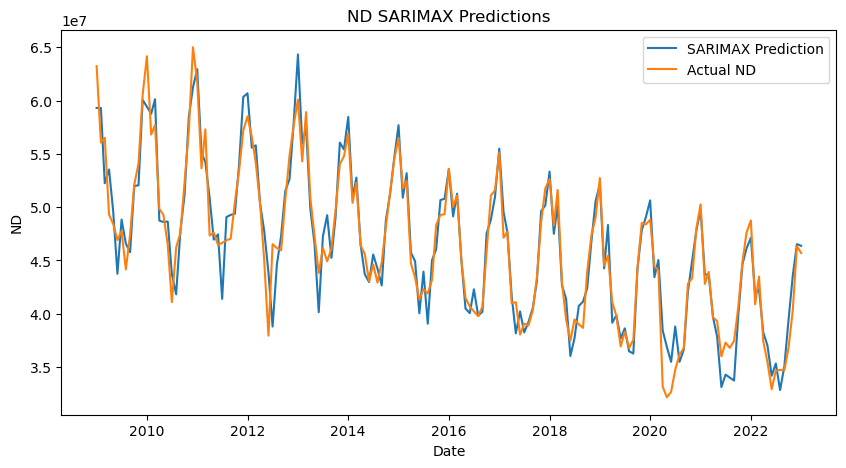

In [524]:
plt.plot(df_monthly['SARIMAX_predict'], label='SARIMAX Prediction')
plt.plot(df_monthly['nd'], label='Actual ND')


plt.title('ND SARIMAX Predictions')
plt.xlabel('Date')
plt.ylabel('ND')
plt.legend() 
plt.show()

In [525]:
#Measure error metrics 
SARIMAX_train_mape = mean_absolute_percentage_error(train, df_monthly.loc[train.index, 'SARIMAX_predict'])
SARIMAX_test_mape = mean_absolute_percentage_error(test, df_monthly.loc[test.index, 'SARIMAX_predict'])
SARIMAX_train_mae = mean_absolute_error(train, df_monthly.loc[train.index, 'SARIMAX_predict'])
SARIMAX_test_mae = mean_absolute_error(test, df_monthly.loc[test.index, 'SARIMAX_predict'])

#Print results
print(f"SARIMAX Train MAE: {round(SARIMAX_train_mae)}")
print(f"SARIMAX Test MAE: {round(SARIMAX_test_mae)}")
print(f"SARIMAX Train MAPE: {round(SARIMAX_train_mape, 2)}%")
print(f"SARIMAX Test MAPE: {round(SARIMAX_test_mape, 2)}%")

SARIMAX Train MAE: 1608049
SARIMAX Test MAE: 1417350
SARIMAX Train MAPE: 3.43%
SARIMAX Test MAPE: 3.73%


In [526]:
#Store results in the results df. 
results.loc[results['model'] == 'SARIMAX', 'Train_MAE'] = SARIMAX_train_mae
results.loc[results['model'] == 'SARIMAX', 'Test_MAE'] = SARIMAX_test_mae
results.loc[results['model'] == 'SARIMAX', 'Train_MAPE'] = SARIMAX_train_mape
results.loc[results['model'] == 'SARIMAX', 'Test_MAPE'] = SARIMAX_test_mape
results['model'].replace({'SARIMAX': 'SARIMAX(3,1,2)x(0,1,3,12)'}, inplace=True)
results

,model,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE
0,Simple_Mean,3.957661,5.488195,1.867551e+06,2.126467e+06
1,Rolling_AVG,5.310872,5.135859,2.520438e+06,2.122838e+06
2,"ARIMA(4,0,2)",12.243213,5.152527,6.198869e+06,1.990700e+06
3,"SARIMA(3,1,2)x(0,1,3,12)",4.567475,7.047027,2.184182e+06,2.740520e+06
4,"SARIMAX(3,1,2)x(0,1,3,12)",3.431899,3.730760,1.608049e+06,1.417350e+06


### **5. Data Save**

In [527]:
#Save exog variables for the validation notebook
validation_exog = df_monthly.loc[test_2.index, ['import_export', 'temp']]

In [528]:
df.to_csv('../data/historic_demand_2009_2023_results.csv', index=True)
df_monthly.to_csv('../data/monthly_historic_demand_2009_2023_results.csv', index=True)
results.to_csv('../data/results.csv', index=True)

validation_exog.to_csv('../data/validation_exog.csv', index=True)

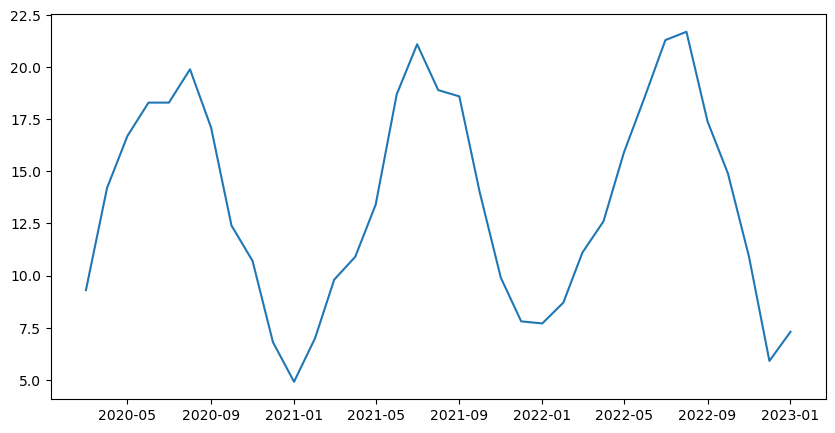

In [529]:
plt.plot(validation_exog['temp'])